In [1]:
import sys, os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed, remove_small_holes, remove_small_objects
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
import pandas

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from registration_utilities import *
from annotation_utilities import *
from learning_utilities import *
from cell_utilities import *

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
stack = 'MD642'

# Same section, different regions

In [6]:
img_w, img_h = metadata_cache['image_shape'][stack]

In [7]:
sec = 200

In [8]:
img = DataManager.load_image(stack=stack, section=sec, resol='lossless', version='cropped_gray')
# tb_mask = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec)

In [9]:
# Specify region

all_regions = []

# region1_x = 2400
# region1_y = 5552
# region1_w = 6808
# region1_h = 3568

region1_x = 4400
region1_y = 7000
region1_w = 1000
region1_h = 1000
#         print region1_x, region1_y, region1_w, region1_h

# tb_region1_xmin = region1_x / 32
# tb_region1_xmax = (region1_x + region1_w) / 32
# tb_region1_ymin = region1_y / 32
# tb_region1_ymax = (region1_y + region1_h) / 32

# if np.count_nonzero(np.r_[tb_mask[tb_region1_ymin, tb_region1_xmin],
# tb_mask[tb_region1_ymin, tb_region1_xmax],
# tb_mask[tb_region1_ymax, tb_region1_xmin],
# tb_mask[tb_region1_ymax, tb_region1_xmax]]) >= 3:
#     break

all_regions.append((region1_x, region1_y, region1_w, region1_h))

In [157]:
# Randomly sample regions

all_regions = []

for _ in range(200):

    while True:
        region1_x = np.random.randint(0, img_w-1000, 1)[0]
        region1_y = np.random.randint(0, img_h-1000, 1)[0]
        region1_w = 1000
        region1_h = 1000
#         print region1_x, region1_y, region1_w, region1_h

        tb_region1_xmin = region1_x / 32
        tb_region1_xmax = (region1_x + region1_w) / 32
        tb_region1_ymin = region1_y / 32
        tb_region1_ymax = (region1_y + region1_h) / 32

        if np.count_nonzero(np.r_[tb_mask[tb_region1_ymin, tb_region1_xmin],
        tb_mask[tb_region1_ymin, tb_region1_xmax],
        tb_mask[tb_region1_ymax, tb_region1_xmin],
        tb_mask[tb_region1_ymax, tb_region1_xmax]]) >= 3:
            break
            
    all_regions.append((region1_x, region1_y, region1_w, region1_h))

# Try Different Thresholds

In [10]:
otsu_all_regions = {}
for region1_x, region1_y, region1_w, region1_h in all_regions:
    img_cropped = img[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]
    thresh_otsu = threshold_otsu(img_cropped)
    otsu_all_regions[(region1_x, region1_y, region1_w, region1_h)] = thresh_otsu

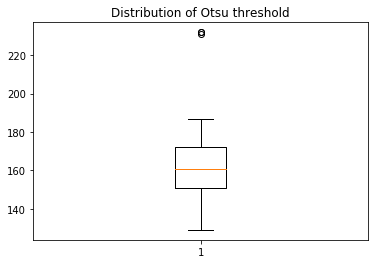

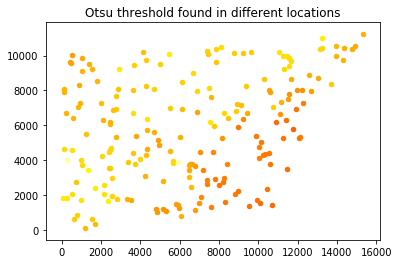

In [159]:
plt.figure();
plt.title('Distribution of Otsu threshold');
plt.boxplot(otsu_all_regions.values());

plt.figure();
plt.title('Otsu threshold found in different locations');
for (x, y, _,_), t in otsu_all_regions.iteritems():
    plt.scatter(x, y, c=plt.cm.hot(t/255.), s=20)

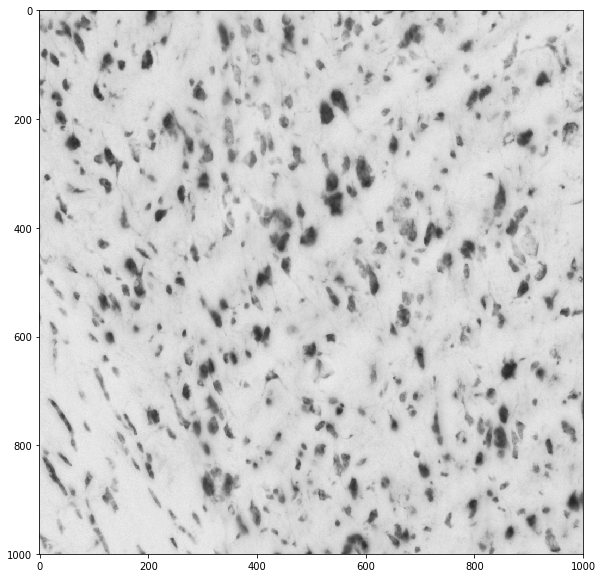

In [11]:
plt.figure(figsize=(10,10));
plt.imshow(img_cropped, plt.cm.gray, vmin=0, vmax=255);

In [90]:
h, _ = np.histogram(img_cropped.flat, bins=np.arange(0,256))
hn = h/float(h.sum())
c = np.cumsum(h)
cn = c/float(h.sum())

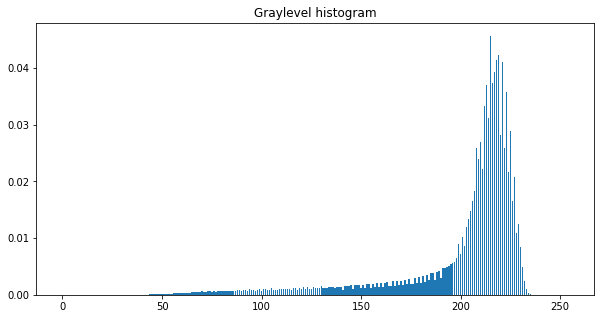

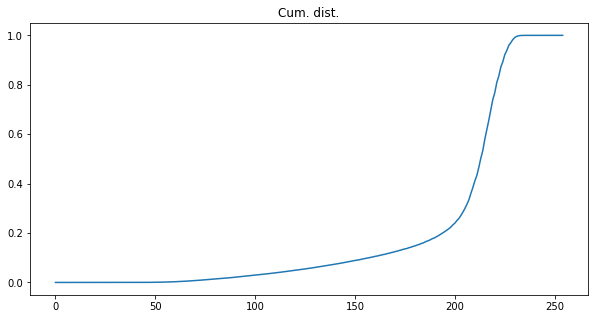

In [91]:
plt.figure(figsize=(10,5));
plt.bar(np.arange(0,256)[:-1], hn);
plt.title('Graylevel histogram');
plt.show();

plt.figure(figsize=(10,5));
plt.plot(np.arange(0,256)[:-1], cn);
plt.title('Cum. dist.');
plt.show();

In [92]:
img_cropped_rgb = gray2rgb(img_cropped)

# Use edge information to find best threshold

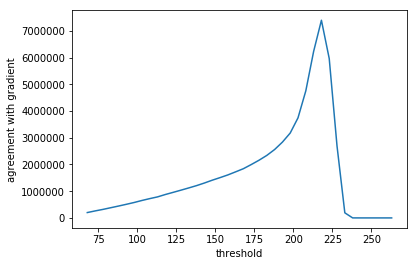

In [64]:
gy, gx = np.gradient(img_as_ubyte(img_cropped))

agreement_score = {}
for threshold in np.arange(thresh_otsu-100, thresh_otsu+100, 5):
# for threshold in [thresh_otsu]:
    gyb, gxb = np.gradient((img_cropped < threshold ).astype(np.float))
    
#     nz = (np.abs(gyb) > 0) | (np.abs(gxb) > 0)
#     score = (gyb[nz]*gy[nz] + gxb[nz]*gx[nz]).mean()

    score = (gyb*gy + gxb*gx).sum()
    agreement_score[threshold] = score

keys, values = zip(*sorted(agreement_score.items()))

plt.plot(keys, values);
plt.xlabel('threshold');
plt.ylabel('agreement with gradient');

In [98]:
best_thresh_by_agreement = keys[np.argmax(values)]

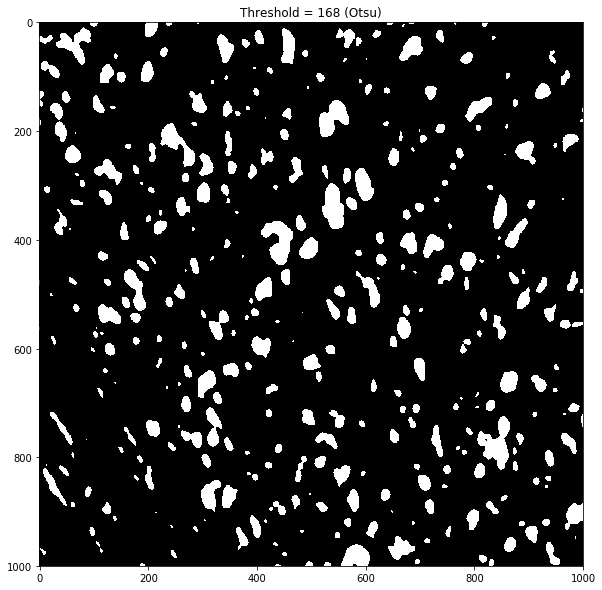

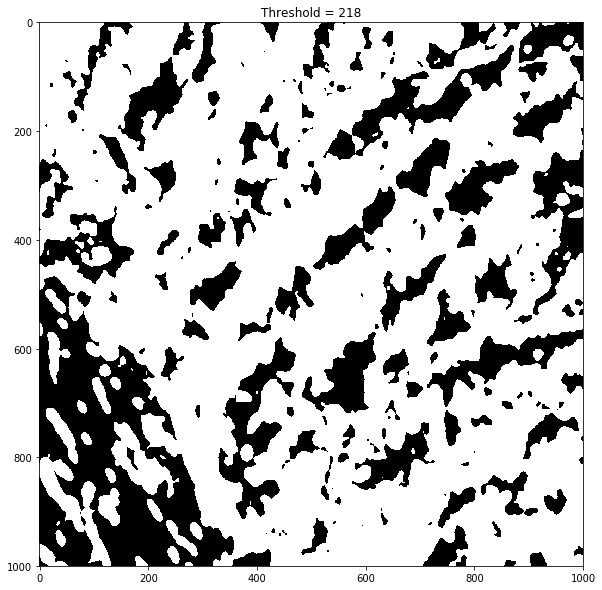

In [101]:
# for threshold in np.arange(thresh_otsu-50, thresh_otsu+100, 20):
for threshold in [thresh_otsu, best_thresh_by_agreement]:
    
    if threshold > 256:
        break
    
#     viz = img_cropped_rgb.copy()
#     for cnt in find_contour_points(img_cropped < threshold)[1]:
#         cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(255,0,0), thickness=2)
    
    viz = img_as_ubyte(gaussian(img_cropped, sigma=3, preserve_range=True) < threshold)

#     viz = img_as_ubyte(img_cropped < threshold)

    plt.figure(figsize=(10, 10));
    plt.imshow(viz, plt.cm.gray, vmin=0, vmax=255);
    if thresh_otsu == threshold:
        plt.title('Threshold = %d (Otsu)' % threshold);
    else:
        plt.title('Threshold = %d' % threshold);
    plt.show();

# Adjacent section, same regions

In [4]:
img_w, img_h = metadata_cache['image_shape'][stack]

In [6]:
sec_groups = [(200, 201, 202, 203)]

In [7]:
region1_w = 500
region1_h = 500

In [14]:
min_blob_area = 10
max_blob_area = 10000

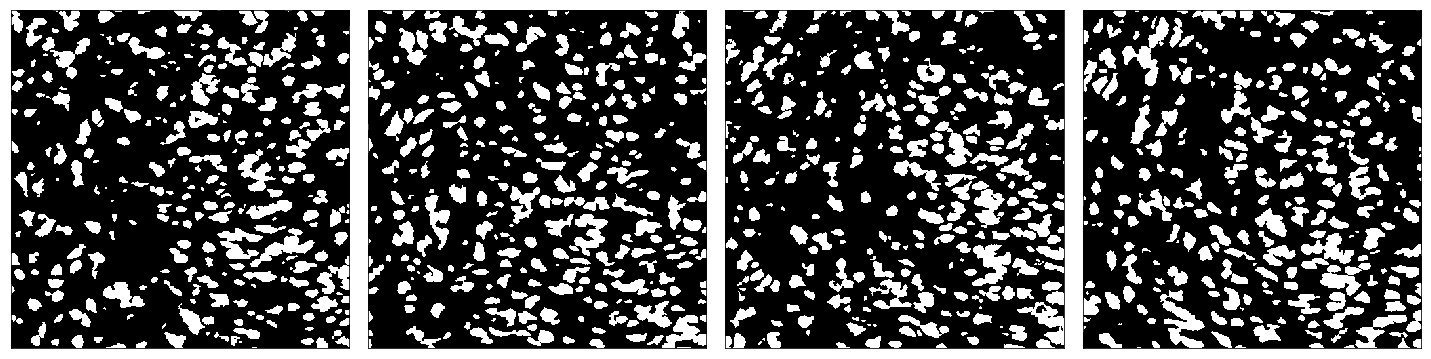

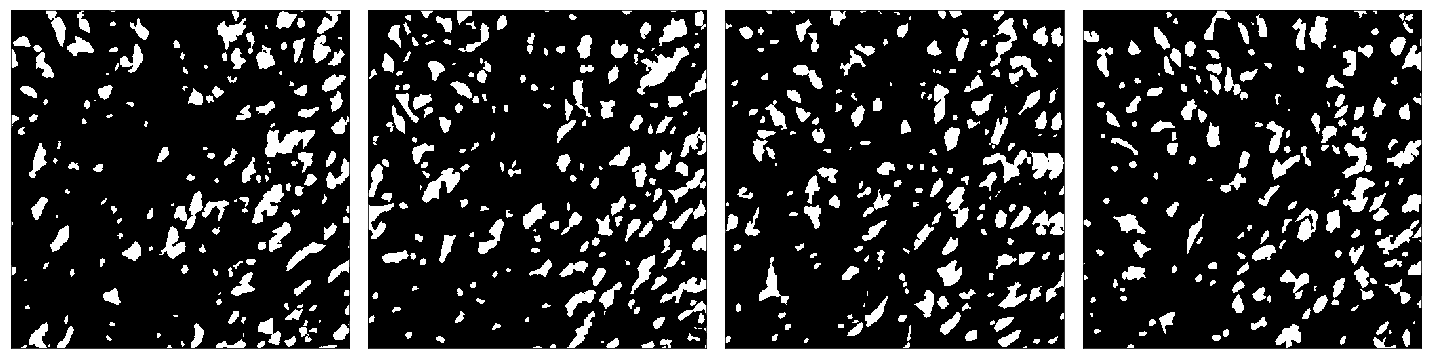

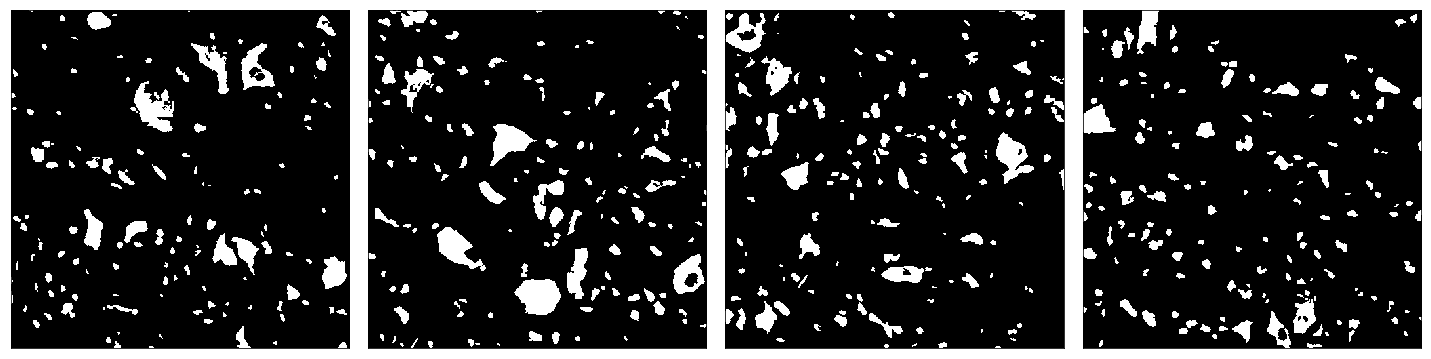

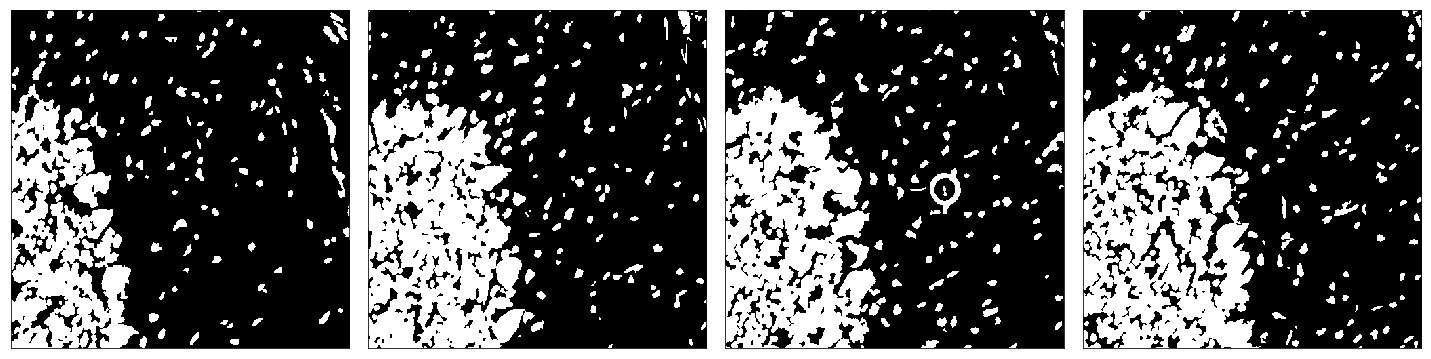

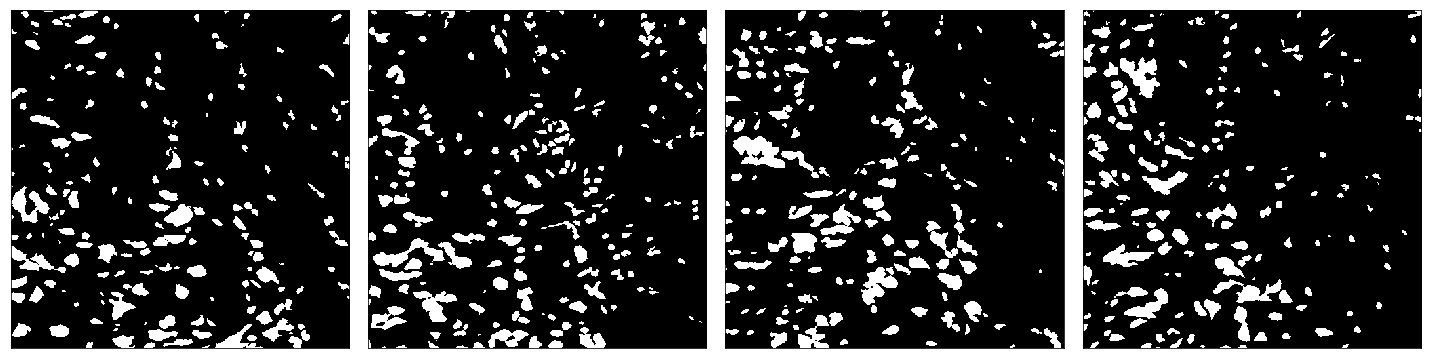

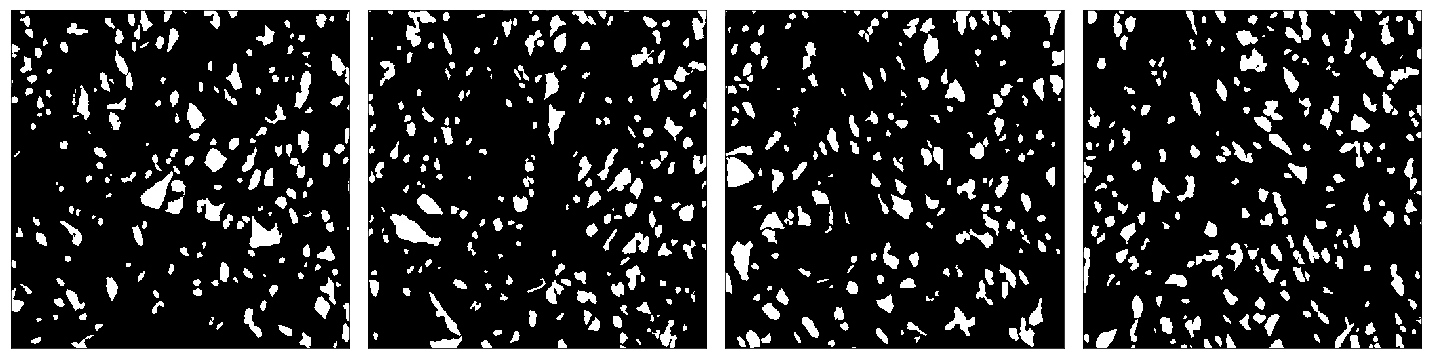

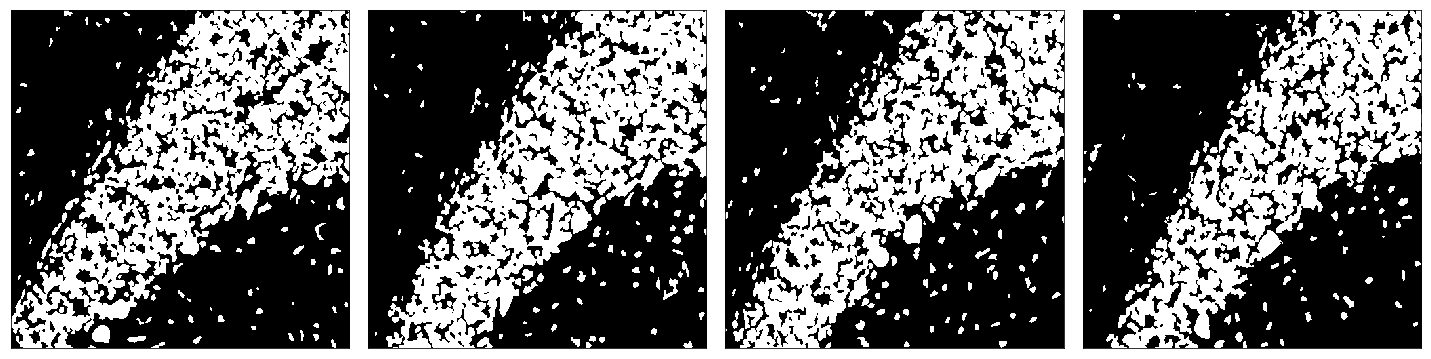

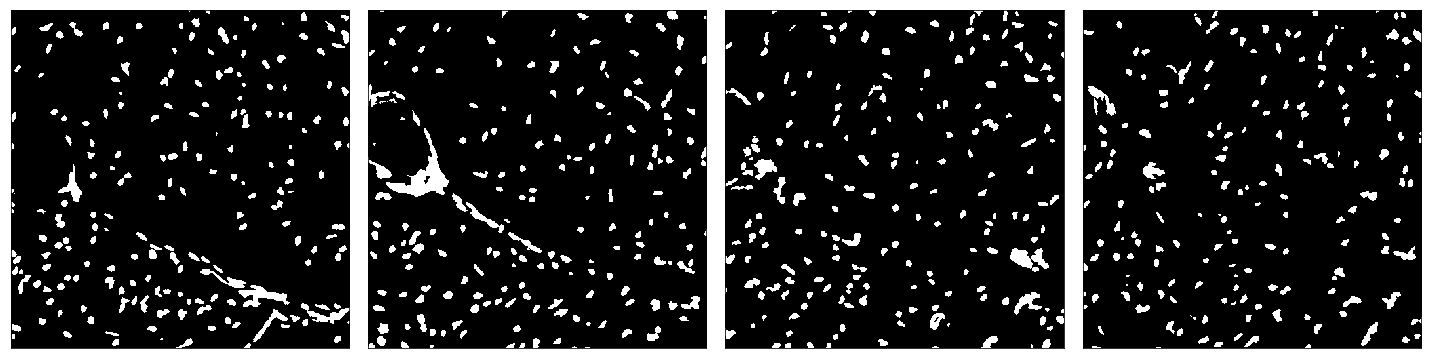

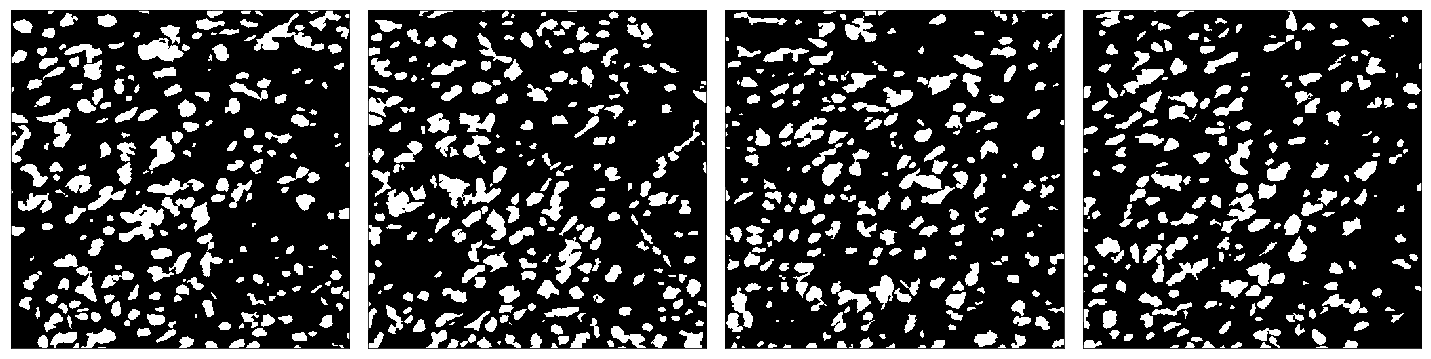

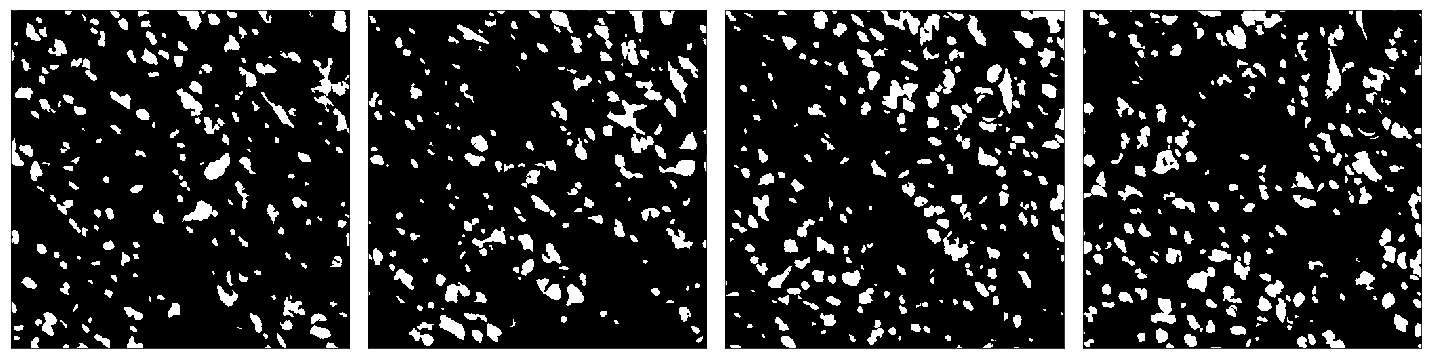

In [15]:
for i, sec_group in enumerate(sec_groups):
    
    tb_mask = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec_group[0])

    all_regions = []

    for _ in range(10):
        while True:
            region1_x = np.random.randint(0, img_w-1000, 1)[0]
            region1_y = np.random.randint(0, img_h-1000, 1)[0]

            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32

            if np.count_nonzero(np.r_[tb_mask[tb_region1_ymin, tb_region1_xmin],
            tb_mask[tb_region1_ymin, tb_region1_xmax],
            tb_mask[tb_region1_ymax, tb_region1_xmin],
            tb_mask[tb_region1_ymax, tb_region1_xmax]]) == 4:
                break
        all_regions.append((region1_x, region1_y, region1_w, region1_h))
    
    images = {sec: imread(DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped_gray'))
              for sec in sec_group}
    
    
    otsu_images_all_regions = []
    for region1_x, region1_y, region1_w, region1_h in all_regions:
        images_same_region = [images[sec][region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]
                              for sec in sec_group]
        
        otsu_images_same_region = []
        for img in images_same_region:
            otsu_t = threshold_otsu(img)
            binary_img = img < otsu_t
            binary_img = remove_small_objects(binary_img, min_size=min_blob_area, connectivity=2)
            binary_img = remove_small_holes(binary_img, min_size=min_blob_area, connectivity=2)
            otsu_images_same_region.append(binary_img)
            
#         display_images_in_grids(images_same_region, nc=len(sec_group), cmap=plt.cm.gray)
        otsu_images_all_regions.append(otsu_images_same_region)
        display_images_in_grids(otsu_images_same_region, nc=len(sec_group), cmap=plt.cm.gray)

# All sections, all regions

In [6]:
patch_size = 500
stride = 500

half_size = patch_size/2

In [8]:
from learning_utilities import *

In [13]:
stack = 'MD593'

In [10]:
gridspec = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
grid_index_to_coordinate = grid_parameters_to_sample_locations(gridspec)

In [14]:
sec = 230
img = imread(DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped_gray'))

In [57]:
rgb_img = img_as_ubyte(gray2rgb(img))

In [29]:
img_w, img_h = metadata_cache['image_shape'][stack]

In [24]:
tb_mask = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)

In [16]:
min_blob_area = 10
max_blob_area = 10000

In [21]:
region1_h = patch_size
region1_w = patch_size

In [36]:
otsu_t_by_grid_index = {}

In [50]:
binary_image = np.zeros_like(img, np.bool)

for gi, (x, y) in enumerate(grid_index_to_coordinate):
    
    region1_y = y - half_size
    region1_x = x - half_size
    
    region_img = img[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]

    if region1_x + region1_w >= img_w or region1_y + region1_h >= img_h:
        continue
    
    tb_region1_xmin = region1_x / 32
    tb_region1_xmax = (region1_x + region1_w) / 32
    tb_region1_ymin = region1_y / 32
    tb_region1_ymax = (region1_y + region1_h) / 32

    if np.count_nonzero(np.r_[tb_mask[tb_region1_ymin, tb_region1_xmin],
        tb_mask[tb_region1_ymin, tb_region1_xmax],
        tb_mask[tb_region1_ymax, tb_region1_xmin],
        tb_mask[tb_region1_ymax, tb_region1_xmax]]) == 0:
        continue
        
    otsu_t = threshold_otsu(region_img)    
    otsu_t_by_grid_index[gi] = otsu_t
    if otsu_t < 130 or otsu_t > 200:
        continue
    binary_img = region_img < otsu_t
    binary_img = remove_small_objects(binary_img, min_size=min_blob_area, connectivity=2)
    binary_img = remove_small_holes(binary_img, min_size=min_blob_area, connectivity=2)
    binary_image[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w] = binary_img.copy()

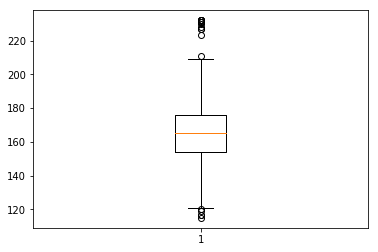

In [51]:
plt.boxplot(otsu_t_by_grid_index.values());

In [54]:
def visualize_blob_contour(binary_img, rgb_img):
    
    viz = rgb_img.copy()
    for cnt in find_contour_points(binary_img)[1]:
        cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, color=(255,0,0), thickness=2)
    return viz

In [59]:
display_image(visualize_blob_contour(binary_image[5000:6000, 5000:6000], rgb_img[5000:6000, 5000:6000]))

/shared/MouseBrainAtlas/cells/tmp.jpg

In [53]:
display_image(binary_image[5000:6000, 5000:6000])

/shared/MouseBrainAtlas/cells/tmp.jpg

In [297]:
# Stretch contrast

vmin = np.percentile(im_cropped, 0)
vmax = np.percentile(im_cropped, 100)
im_cropped_autoleveled = (im_cropped - vmin) / (vmax - vmin)
im_cropped_autoleveled = np.maximum(np.minimum(im_cropped_autoleveled, 1), 0)
im_cropped_autoleveled = 255 - img_as_ubyte(im_cropped_autoleveled)

# OR
# im_cropped_autoleveled = 255 - im_cropped

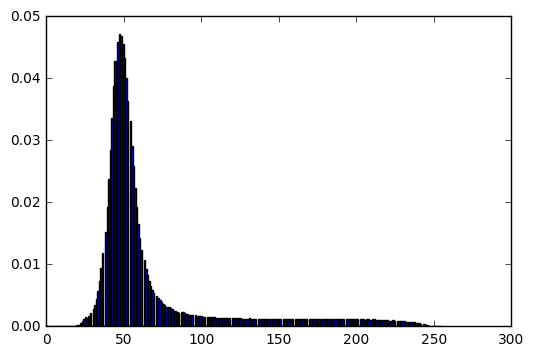

In [298]:
plt.hist(im_cropped_autoleveled.flatten(), bins=256, normed=True);
plt.show();

In [219]:
# contour_viz_fn = DETECTED_CELLS_DIR + '/MD589/MD589-N34-2015.07.30-18.20.43_MD589_2_0101/MD589-N34-2015.07.30-18.20.43_MD589_2_0101_blobContours_viz_farsight.png'
# contour_viz = cv2.imread(contour_viz_fn)
# contour_viz[5700:6700, 3000:4500]

# Binarization

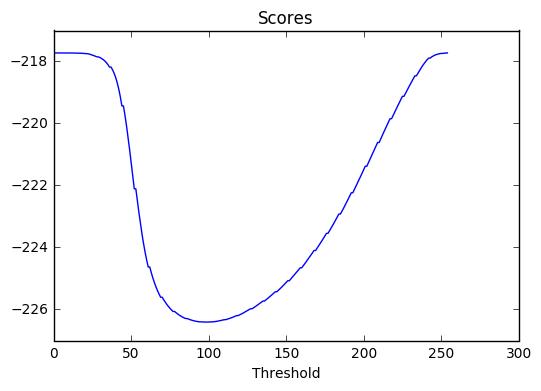

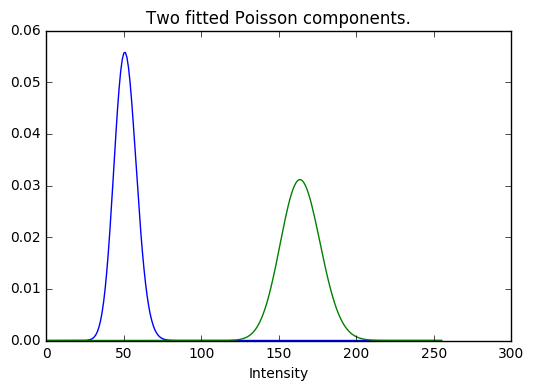

In [301]:
# Binarization: Poisson fitting.

counts, edges = np.histogram(im_cropped_autoleveled.flatten(), bins=256)
h = counts/float(np.sum(counts))
vals = edges[:-1]

# plt.hist(im_cropped_autoleveled.flatten(), bins=256, normed=True);
# plt.show();

mu = np.mean(im_cropped_autoleveled)

prior0s = np.zeros((256,))
prior1s = np.zeros((256,))
mu0s = np.zeros((256,))
mu1s = np.zeros((256,))

scores = {}
for t in range(0, 256):

    p0 = h[vals <= t].sum()
    p1 = 1 - p0
    hv = h * vals
    hv0 = hv[vals <= t].sum()
    hv1 = hv.sum() - hv0
    mu0 = hv0 / p0
    mu1 = hv1 / p1
    r = mu - p0*(np.log(p0)+mu0*np.log(mu0)) - p1*(np.log(p1)+mu1*np.log(mu1))
    scores[t] = r
    
    prior0s[t] = p0
    prior1s[t] = p1
    mu0s[t] = mu0
    mu1s[t] = mu1
    
poisson_thresh = np.argsort(scores.values())[0]

plt.plot(scores.values());
plt.title('Scores');
plt.xlabel('Threshold');
plt.show();

from scipy.stats import poisson
p0s = [poisson.pmf(v, mu0s[poisson_thresh]) for v in range(256)]
p1s = [poisson.pmf(v, mu1s[poisson_thresh]) for v in range(256)]
plt.plot(p0s);
plt.plot(p1s);
plt.title('Two fitted Poisson components.');
plt.xlabel('Intensity');
plt.show();

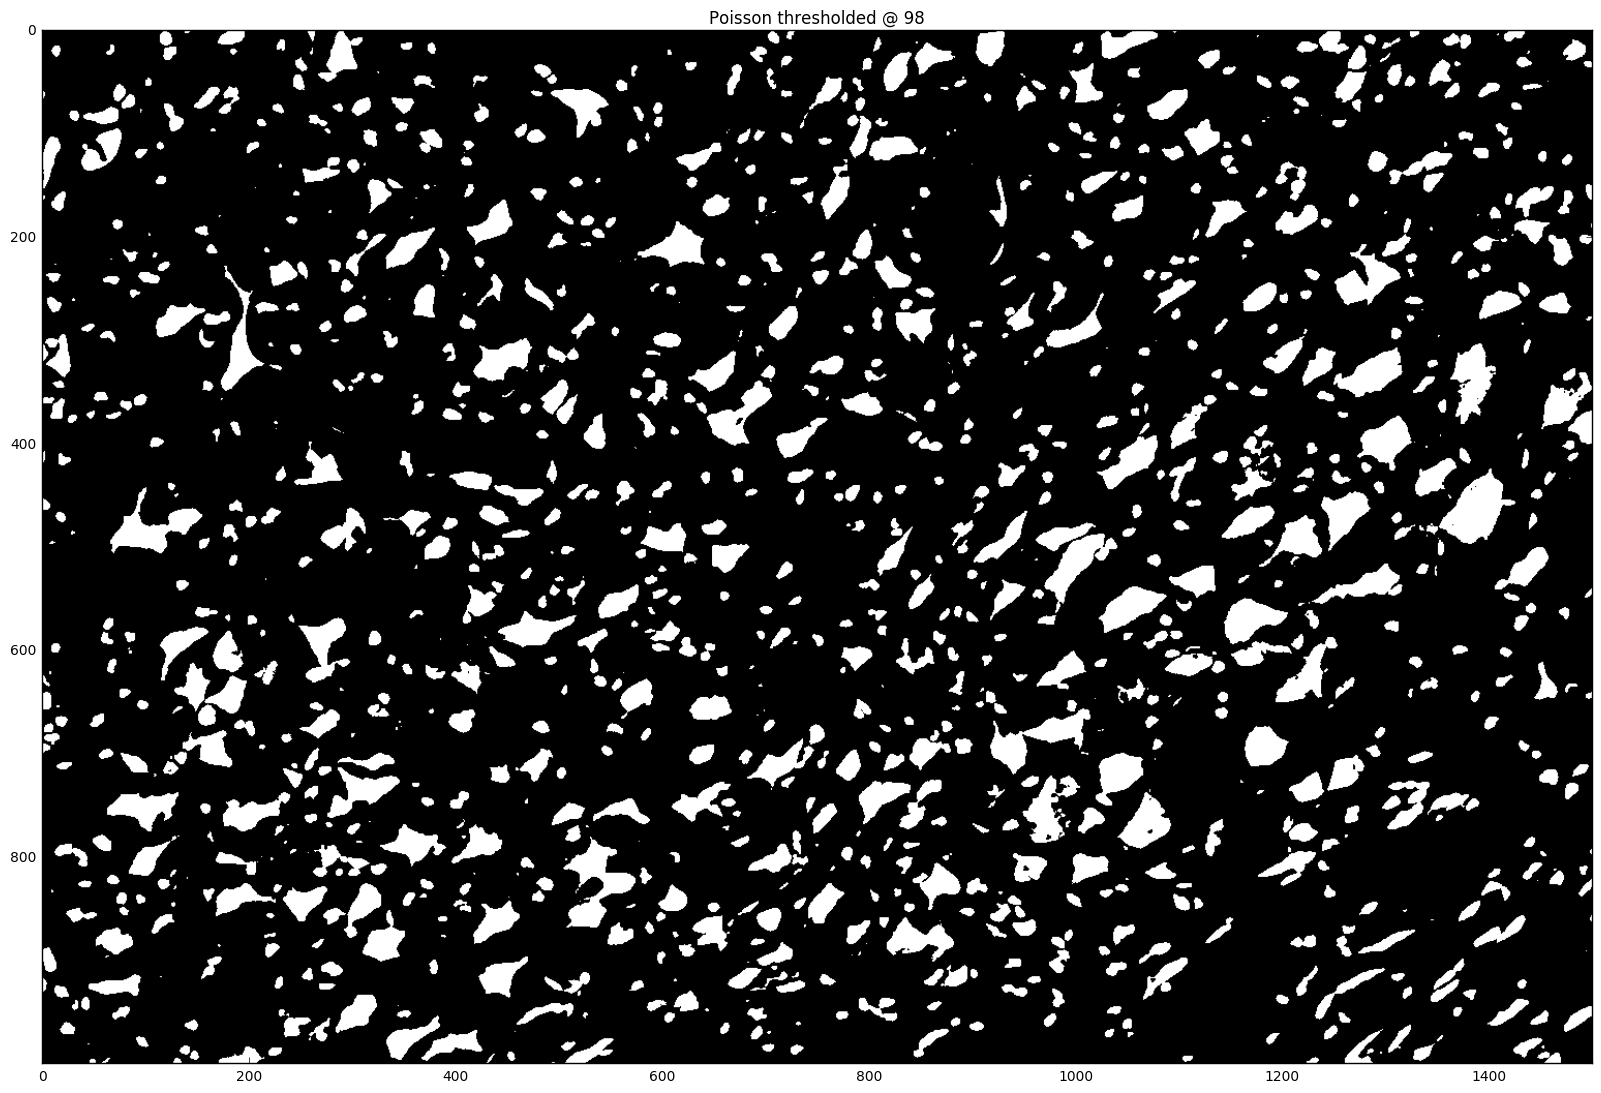

In [305]:
plt.figure(figsize=(20,20));
plt.imshow(im_cropped_autoleveled > poisson_thresh, cmap=plt.cm.gray)
plt.title('Poisson thresholded @ %d' % poisson_thresh);
plt.show();

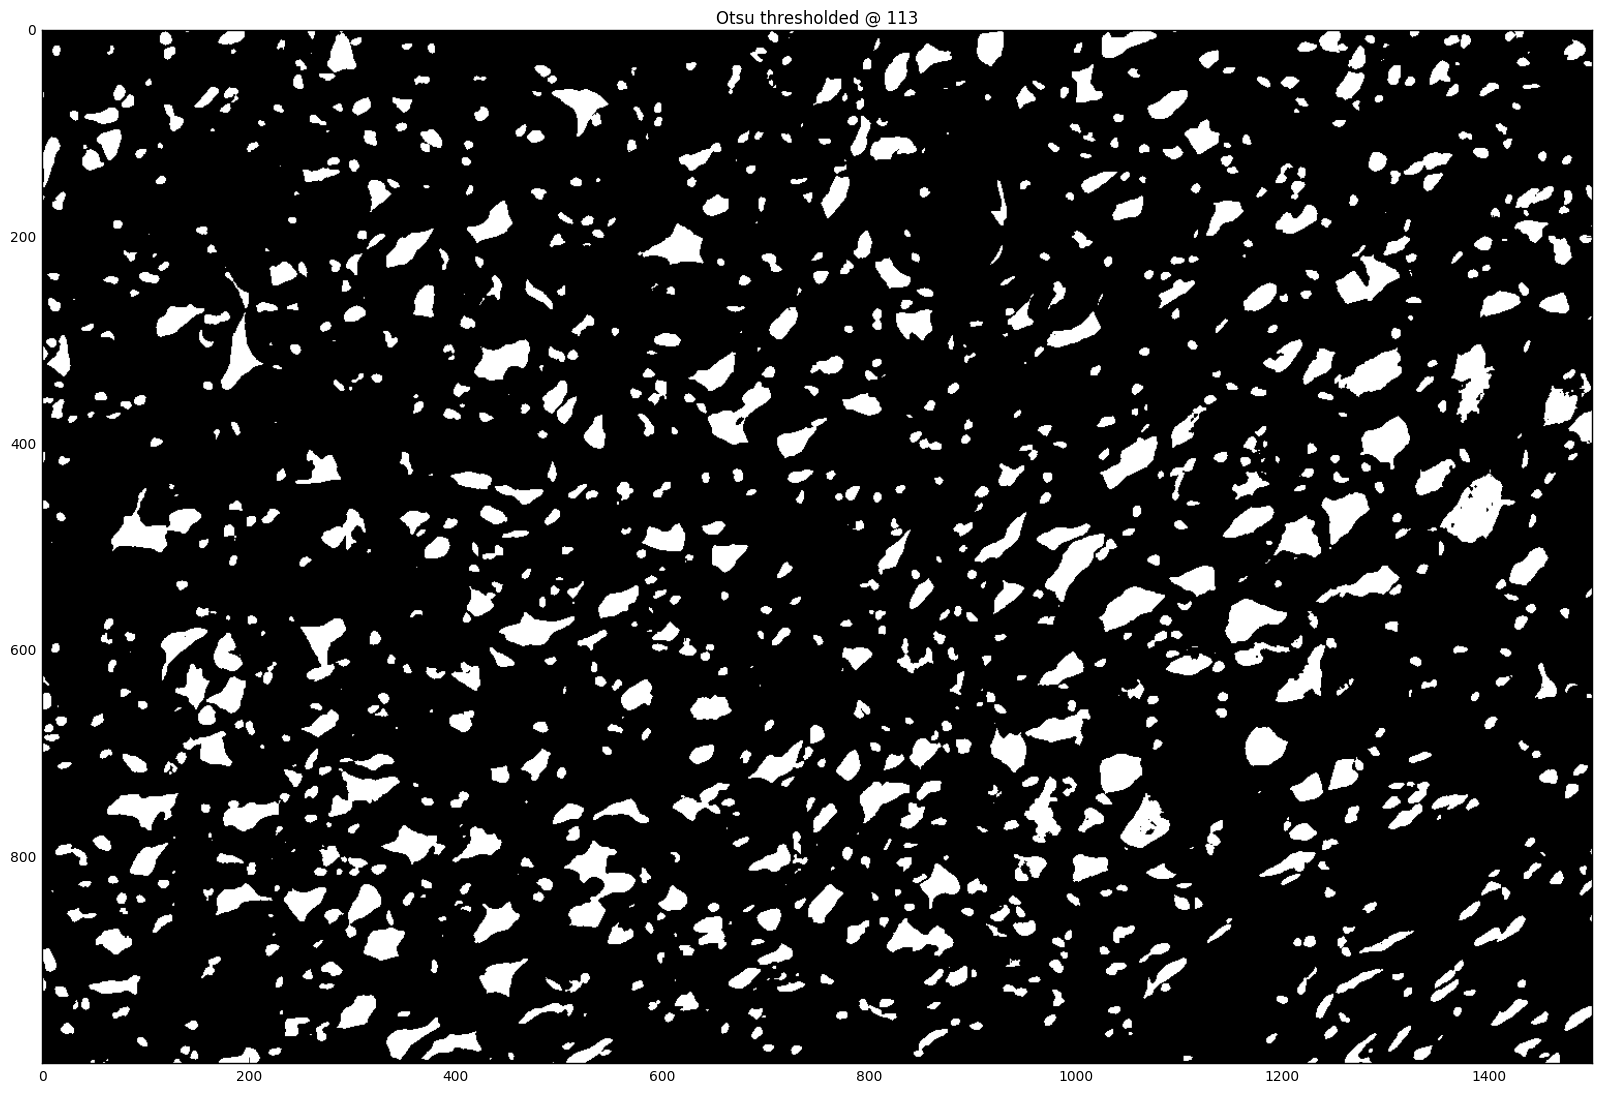

In [304]:
from skimage.filters import threshold_otsu
otsu_thresh = threshold_otsu(im_cropped_autoleveled)

plt.figure(figsize=(20,20));
plt.imshow(im_cropped_autoleveled > otsu_thresh, cmap=plt.cm.gray)
plt.title('Otsu thresholded @ %d' % otsu_thresh);
plt.show();

# Canny

In [177]:
gy, gx = np.gradient(im_cropped_autoleveled)
g = np.sqrt(gx**2 + gy**2)

plt.hist(g.flatten(), bins=100);
viz = plt.cm.gray(g);
display_image(viz)

In [ ]:
gr = (g - 50.)/(200.-50.)
gr = np.minimum(np.maximum(gr, 0), 1)
viz = plt.cm.gray(gr);

# plt.figure(figsize=(20,20));
# plt.imshow(viz, cmap=plt.cm.gray)
# plt.show();

from skimage.feature import canny

im_edges = canny(im_cropped_autoleveled, sigma=1., 
                 low_threshold=50, high_threshold=100, 
                 mask=None, use_quantiles=False)

In [ ]:
viz = gray2rgb(im_cropped_autoleveled)
viz[im_edges] = (255,0,0)

plt.figure(figsize=(20,20));
plt.imshow(viz, cmap=plt.cm.gray)
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(im_edges, cmap=plt.cm.gray)
plt.show();

# Graphcut

In [53]:
import itertools
node_locations = list(itertools.product(range(im_cropped_h), range(im_cropped_w)))

In [52]:
y_diff = np.diff(im_cropped_autoleveled, axis=0)
x_diff = np.diff(im_cropped_autoleveled, axis=1)

In [199]:
sigma = 10.
sigma_sq = 2*sigma**2
beta = 1e-2

In [215]:
import maxflow

graph = maxflow.Graph[float](0, 0)

n = im_cropped_h * im_cropped_w
nodeids = graph.add_grid_nodes(n)

for node_id in range(n):
    
    y, x = node_locations[node_id]
       
    if node_id - 1 > 0 and y > 0 and y < im_cropped_h - 1 and x - 1 > 0 and x - 1 < im_cropped_w - 1:
        weight = np.exp(-x_diff[y,x-1]**2/sigma_sq)
        graph.add_edge(node_id, node_id - 1, weight, weight)
    
    if node_id + 1 < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-x_diff[y,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id + 1, weight, weight)
        
    if node_id - im_cropped_w > 0 and y - 1 > 0 and y - 1 < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-y_diff[y-1,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id - im_cropped_w, weight, weight)
    
    if node_id + im_cropped_w < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-y_diff[y,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id + im_cropped_w, weight, weight)
        
    graph.add_tedge(node_id, beta * -np.log(p0s[im_cropped_autoleveled[y,x]]), 
                    beta * -np.log(p1s[im_cropped_autoleveled[y,x]]))

In [306]:
graph.maxflow();

node_mincut_labels = graph.get_grid_segments(nodeids)
mincut_labelmap = node_mincut_labels.reshape((im_cropped_h, im_cropped_w))

# print np.count_nonzero(~mincut_labelmap != im_cropped_threshed)

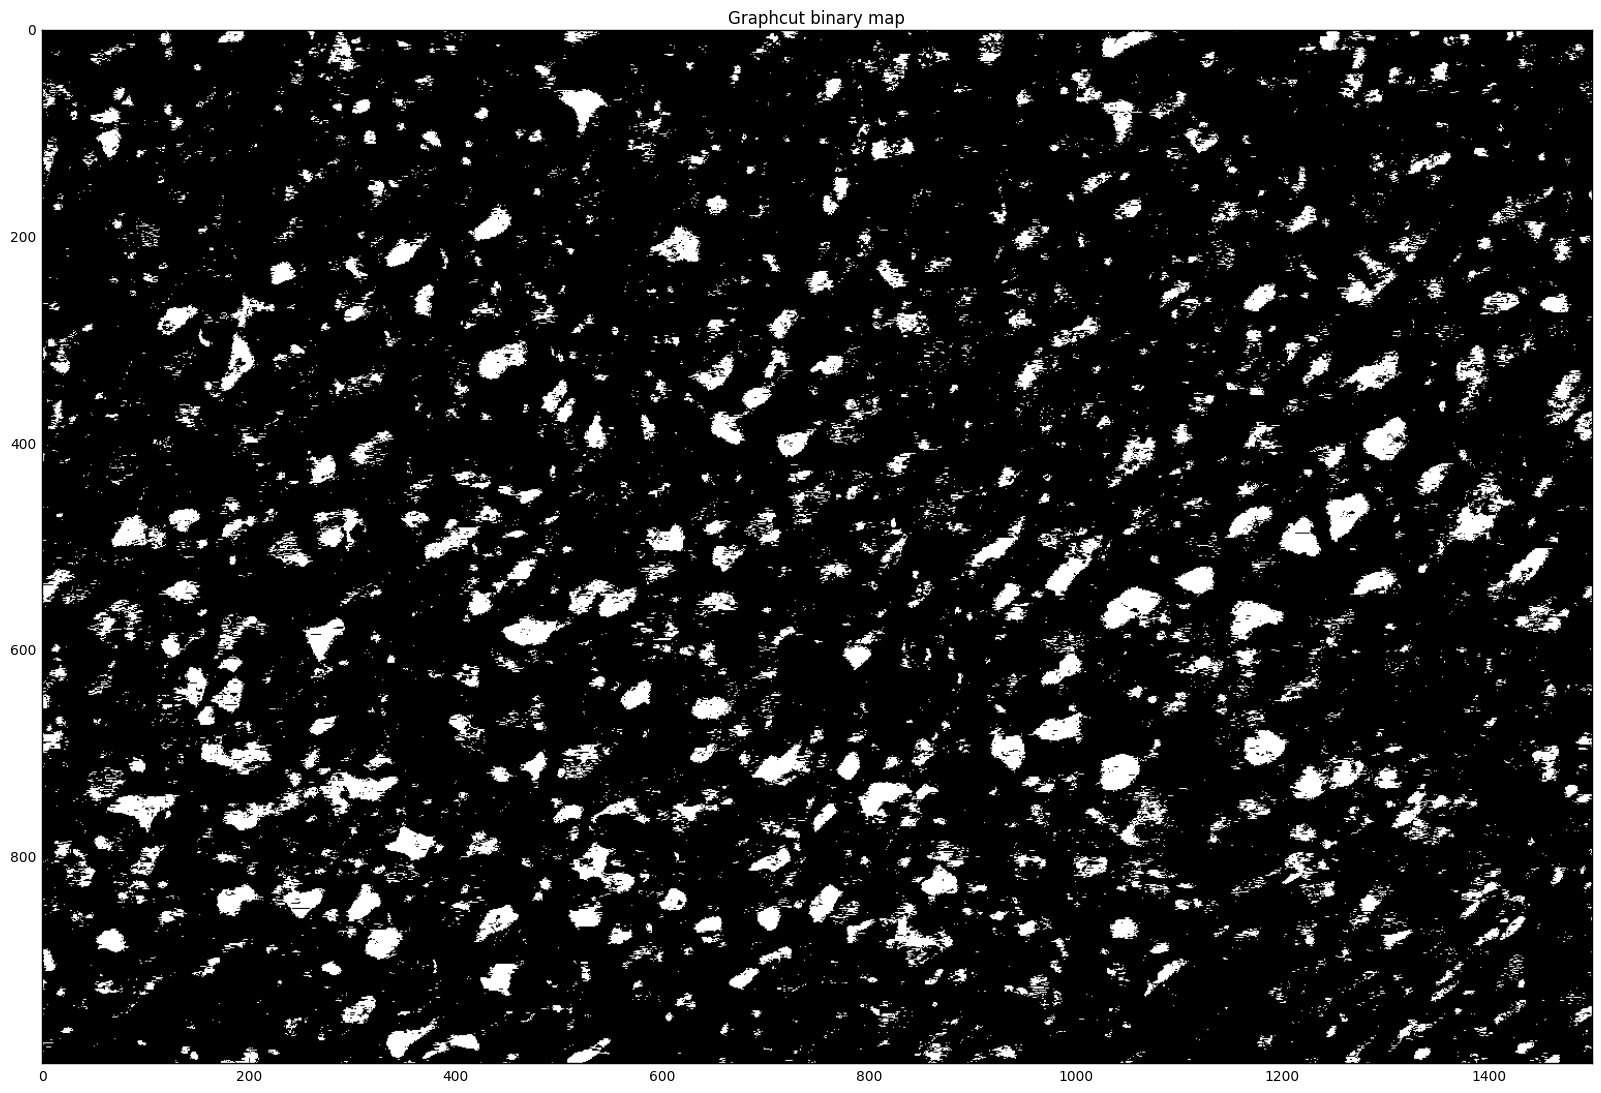

In [307]:
plt.figure(figsize=(20,20));
plt.imshow(~mincut_labelmap, cmap=plt.cm.gray)
plt.title('Graphcut binary map');
plt.show();

# SLIC

In [104]:
from skimage.segmentation import slic, mark_boundaries

In [115]:
slic_labelmap = slic(im_cropped_autoleveled, n_segments=10000, compactness=1.0, max_iter=1000, 
                           sigma=0, spacing=None, 
     multichannel=False, convert2lab=False, 
     enforce_connectivity=True, min_size_factor=0.5, 
     max_size_factor=3, slic_zero=False)
viz = mark_boundaries(im_cropped_autoleveled, label_img=slic_labelmap)
display_image(viz)

# LoG

In [92]:
from skimage.feature import blob_log, blob_dog

In [100]:
for threshold in np.arange(0.1, 1, 0.1):
    y_x_sigma_list = blob_log(im_cropped_autoleveled, min_sigma=3, max_sigma=50, num_sigma=10, 
                              threshold=threshold, overlap=0.9, log_scale=False)

    #     y_x_sigma_list = blob_dog(im_cropped_autoleveled, min_sigma=3, max_sigma=50, 
    #                                   threshold=threshold, overlap=0.9)

    viz = img_as_ubyte(gray2rgb(im_cropped_autoleveled))
    for y,x,sigma in y_x_sigma_list:
        cv2.circle(viz, (int(x), int(y)), radius=int(sigma), color=(255,0,0), thickness=2)

    fn = DETECTED_CELLS_DIR + '/MD589/MD589-N34-2015.07.30-18.20.43_MD589_2_0101/MD589-N34-2015.07.30-18.20.43_MD589_2_0101_LoG_thresh%.2f.png' % \
            threshold

    cv2.imwrite(fn, viz[..., ::-1])